<a href="https://colab.research.google.com/github/YIZHE12/music_recom/blob/master/music_recommendation_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music recommendation system using TensorFlow and Keras

## Load all require packages 

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf
from sklearn import preprocessing
import time
import seaborn as sns
import re
from gensim.models import word2vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os
from keras.models import Sequential

from keras.layers import Embedding

tf.logging.set_verbosity(tf.logging.ERROR)


# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols


# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials


Using TensorFlow backend.


## Load data

song_df_1 is the table of user's listening record, which has columns of 'user_id',' 'song_id', 'listen_count'

song_df_2 is song metadata file, which has 'song_id',	'title',	'release',	'artist_name',	'year'

In [2]:
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

song_df_1 = pd.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_df_2 =  pd.read_csv(songs_metadata_file)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


In [3]:
song_df_1.head()

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [4]:
song_df_2.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [6]:
len(song_df_2.artist_name.unique())

72665

In [7]:
len(song_df_2.title.unique())

702429

## Data cleaning
The song_id and user_id is a very long string, we can increase efficiency by converting this long string to a number by label encoding


In [0]:
le_song_id = preprocessing.LabelEncoder()
le_song_id.fit(song_df_2.song_id)
song_df_2.song_id = le_song_id.transform(song_df_2.song_id)
song_df_1.song_id = le_song_id.transform(song_df_1.song_id)

In [0]:
le_user_id = preprocessing.LabelEncoder()
song_df_1.user_id = le_user_id.fit_transform(song_df_1.user_id)

## Merge two dataset

In [0]:
#Merge the two dataframes above to create input dataframe for recommender systems
song_df = pd.merge(song_df_1, \
                   song_df_2.drop_duplicates(['song_id']), \
                   on="song_id", how="left")

In [8]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,54961,17370,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,1,Stronger,Graduation,Kanye West,2007
3,54961,83689,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [12]:
song_df.describe(include=[np.int, np.object])

,user_id,song_id,listen_count,title,release,artist_name,year
count,2000000.000,2000000.000,2000000.000,2000000,2000000,2000000,2000000.000
unique,nan,nan,nan,9567,5388,3375,nan
top,nan,nan,nan,Sehr kosmisch,Greatest Hits,Coldplay,nan
freq,nan,nan,nan,8277,15692,29422,nan
mean,38135.988,509769.531,3.045,NaN,NaN,NaN,1628.645
...,...,...,...,...,...,...,...
min,0.000,19.000,1.000,NaN,NaN,NaN,0.000
25%,19112.000,262268.000,1.000,NaN,NaN,NaN,1984.000
50%,37949.000,523210.000,1.000,NaN,NaN,NaN,2002.000
75%,57135.000,760352.000,3.000,NaN,NaN,NaN,2007.000


In [0]:
song_df = song_df.fillna(value=0)

#### Hiistogram of listen_count In log scale

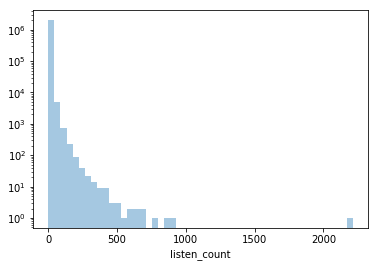

In [14]:
g = sns.distplot(song_df.listen_count, kde=False, rug=False)
g.set_yscale('log')

#### number of unique user

In [15]:
len(pd.unique(song_df.user_id))

76353

#### number of unique song

In [16]:
len(pd.unique(song_df.song_id))

10000

#### check the most popular songs 

In [0]:
song_ratings = song_df_2.merge(
    song_df
    .groupby('song_id', as_index=False)
    .agg({'listen_count': ['count', 'mean']})
    .flatten_cols(),
    on='song_id')


In [0]:
sorted_song = (song_ratings[['title', 'listen_count count', 'listen_count mean']]
 .sort_values('listen_count count', ascending=False))

In [19]:
 sorted_song.head(10)

,title,listen_count count,listen_count mean
8364,Sehr kosmisch,8277,3.750
1197,Undo,7032,7.004
1625,Dog Days Are Over (Radio Edit),6949,3.837
4755,You're The One,6412,8.443
8933,Revelry,6145,6.740
8902,Secrets,5841,3.784
6483,Horn Concerto No. 4 in E flat K495: II. Romanc...,5385,5.785
8269,Fireflies,4795,3.048
8054,Hey_ Soul Sister,4758,3.257
5869,Tive Sim,4548,3.171


## Data Normalization

The maximum number of 'listen_count' is 8277, while the minimal is 0. This large range will create problems for the model and require normalization. 

Here, I first grouped the data by user then normalized the listen_count value.

In [10]:
zscore = lambda x: (x - x.mean()) / x.std() 
# min_max = lambda x: (x - x.min()) / (x.max() - x.min())
norm = song_df.groupby('user_id').transform(zscore)
song_df.listen_count = norm.listen_count 

song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,54961,17370,-0.367,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,0.268,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,-0.367,Stronger,Graduation,Kanye West,2007
3,54961,83689,-0.367,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,-0.367,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [11]:
min_max = lambda x: (x - x.min()) / (x.max() - x.min())
norm = song_df.groupby('user_id').transform(min_max)

song_df.listen_count = norm.listen_count 

song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,54961,17370,0.000,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,0.143,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,0.000,Stronger,Graduation,Kanye West,2007
3,54961,83689,0.000,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,0.000,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [0]:
song_df = song_df.fillna(value=0)

# Build a collaborative filtering model

## CFModel (Collaborative Filtering Model) helper class
This is a simple class to train a matrix factorization model using stochastic gradient descent.

The class constructor takes
- the user embeddings U (a `tf.Variable`).
- the song embeddings V, (a `tf.Variable`).
- a loss to optimize (a `tf.Tensor`).
- an optional list of metrics dictionaries, each mapping a string (the name of the metric) to a tensor. These are evaluated and plotted during training (e.g. training error and test error).

After training, one can access the trained embeddings using the `model.embeddings` dictionary.

Example usage:
```
U_var = ...
V_var = ...
loss = ...
model = CFModel(U_var, V_var, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
song_embeddings = model.embeddings['song_id']
```

In [0]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [0]:
def build_rating_sparse_tensor(song_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `song_id` and `listen_count` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = song_df[['user_id', 'song_id']].values
  values = song_df['listen_count'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[song_df_1.shape[0], song_df_2.shape[0]])


In [0]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, music_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    music_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of music j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(music_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [0]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [0]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "song_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

 iteration 5000: train_error=0.088745, test_error=0.092346

[{'test_error': 0.092346095, 'train_error': 0.08874533}]

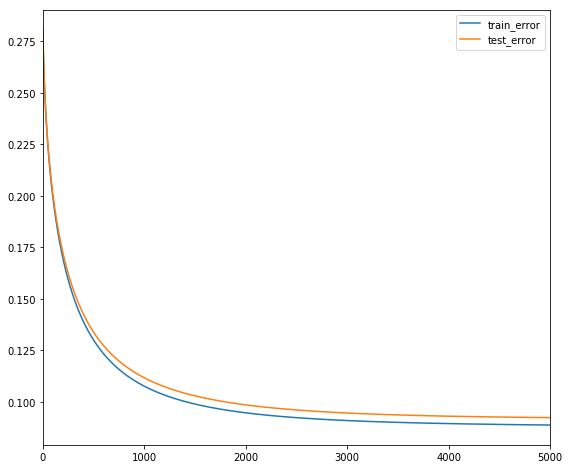

In [28]:
# Build the CF model and train it.
model = build_model(song_df, embedding_dim=3, init_stddev=0.5)
model.train(num_iterations=5000, learning_rate=25.)

## Find similar items

In [0]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [0]:
def music_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for music ids that match the given substring.
  ids =  music[music['title']==title_substring].index.values
  titles = music.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no music with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching music. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  song_id = ids[0]
  scores = compute_scores(
      model.embeddings["song_id"][song_id], model.embeddings["song_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': music['title'],
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

#### Find similar songs to Stronger

In [0]:
music = song_df_2

In [32]:
music_neighbors(model, "Stronger", COSINE)

Nearest neighbors of : Stronger.
[Found more than one matching music. Other candidates: Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger]


,cosine score,titles
5945,1.000,Stronger
155024,1.000,This City Is Contagious (Album Version)
680189,1.000,Suuria kuvioita
449113,1.000,Forget His Facade
43355,1.000,Takin You Back
988491,1.000,Riverdale


In [33]:
music_neighbors(model, "Stronger", DOT)

Nearest neighbors of : Stronger.
[Found more than one matching music. Other candidates: Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger]


,dot score,titles
869725,2.569,Flora's Song
840192,2.466,Love Is A Stranger
78251,2.320,White Balloons
369984,2.259,Quiero Ser Un Pez (Maqueta)
529659,2.253,Police State
540117,2.200,Always Free


## Regularization In Matrix Factorization

In the previous section, the loss was defined as the mean squared error on the observed part of the rating matrix.  This can be problematic as the model does not learn how to place the embeddings of irrelevant movies. This phenomenon is known as *folding*.

We will add regularization terms that will address this issue. We will use two types of regularization:
- Regularization of the model parameters. This is a common $\ell_2$ regularization term on the embedding matrices, given by $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.

The total loss is then given by
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
where $\lambda_r$ and $\lambda_g$ are two regularization coefficients (hyper-parameters).

In [0]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of song ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "song_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 2000: train_error_observed=0.088582, test_error_observed=0.090141, observed_loss=0.088582, regularization_loss=0.017290, gravity_loss=0.000214

[{'test_error_observed': 0.090140775, 'train_error_observed': 0.08858184},
 {'gravity_loss': 0.00021352999,
  'observed_loss': 0.08858184,
  'regularization_loss': 0.01729011}]

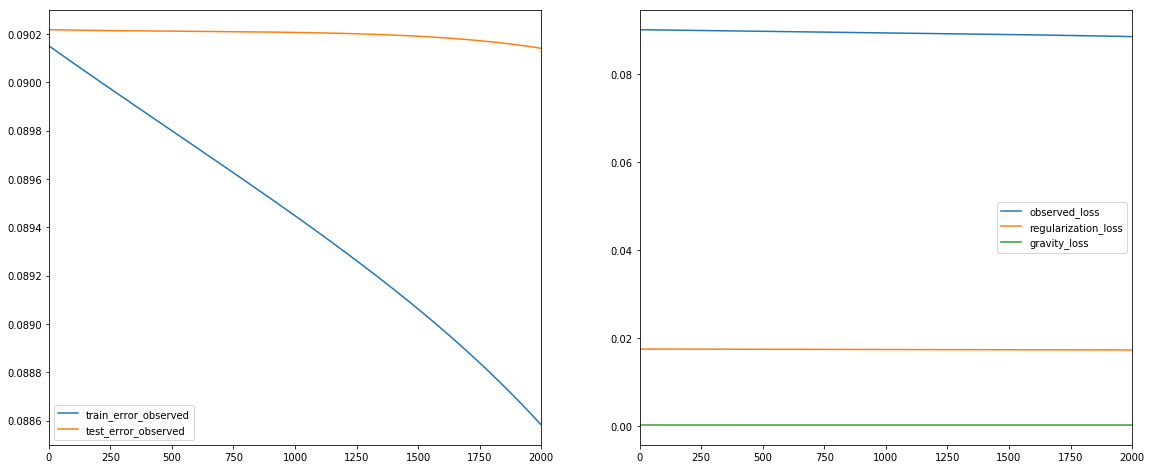

In [35]:
reg_model = build_regularized_model(
    song_df, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

In [36]:
np.shape(reg_model.embeddings['song_id'])

(1000000, 35)

In [37]:
np.shape(reg_model.embeddings['user_id'])

(2000000, 35)

In [38]:
music_neighbors(reg_model, "Stronger", DOT)

Nearest neighbors of : Stronger.
[Found more than one matching music. Other candidates: Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger]


,dot score,titles
5945,0.116,Stronger
155967,0.078,Time (House Mix)
907247,0.076,On The Bus
489330,0.076,Wistful Moment
58814,0.075,Cut A Long Story Short
343067,0.073,Feel Like Makin' Love (LP Version)


In [39]:
music_neighbors(reg_model, "Stronger", COSINE)

Nearest neighbors of : Stronger.
[Found more than one matching music. Other candidates: Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger]


,cosine score,titles
5945,1.000,Stronger
58814,0.678,Cut A Long Story Short
862114,0.667,And I Love Her
701276,0.656,Make It Like It Was
222015,0.656,Shawdi
279267,0.654,Choices


In [0]:
check_user_list = song_df[song_df.title == 'Stronger'].user_id.unique()

In [41]:
print(song_df[song_df.user_id == check_user_list[100]].title.unique())

['Lemme Get That' 'Hot N Cold (Manhattan Clique Remix Radio Edit)'
 'Stronger' 'All Star' 'I Kissed A Girl' "Wavin'  Flag" 'Magic'
 'Without Me' 'LoveGame']


## Make your own prediction to build a play list

In [0]:
USER_RATINGS = True #@param {type:"boolean"}
users = song_df_1

In [43]:
# @title Run to create a spreadsheet, then use it to enter your ratings.
# Authenticate user.
if USER_RATINGS:
  auth.authenticate_user()
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  # Create the spreadsheet and print a link to it.
  try:
    sh = gc.open('music-test')
  except(gspread.SpreadsheetNotFound):
    sh = gc.create('music-test')

  worksheet = sh.sheet1
  titles = music['title'].values[0:1000] # take the first 100 songs
#   titles = [re.sub(r'/\s+/g', '-', str(item)) for item in titles]
  cell_list = worksheet.range(1, 1, len(titles), 1)
  for cell, title in zip(cell_list, titles):
    cell.value = title
  worksheet.update_cells(cell_list)
  print("Link to the spreadsheet: "
        "https://docs.google.com/spreadsheets/d/{}/edit".format(sh.id))

Link to the spreadsheet: https://docs.google.com/spreadsheets/d/1GUMvcKhRrUyTbzcwhk32Dg8jYsEbu0lEPDmZSHnRipY/edit


In [46]:
# Run to load your ratings.
# Load the ratings from the spreadsheet and create a DataFrame.
if USER_RATINGS:
  my_ratings = pd.DataFrame.from_records(worksheet.get_all_values()).reset_index()
  my_ratings = my_ratings[my_ratings[1] != '']
  my_ratings = pd.DataFrame({
      'user_id': "943",
      'title':list(map(str, my_ratings[0])),
      'listen_count': list(map(float, my_ratings[1])),
  })
  
  my_ratings.merge(song_df_2, on="title", how="left")
   
  # Remove previous ratings.
  song_df = song_df[song_df.user_id != "943"]
  # Add new ratings.
  song_df = song_df.append(my_ratings, ignore_index=True)
  # Add new user to the users DataFrame.
  if users.shape[0] == 943:
    users = users.append(users.iloc[942], ignore_index=True)
    users["user_id"][943] = "943"
  print("Added your %d ratings; you have great taste!" % len(my_ratings))
  song_df[song_df.user_id=="943"].merge(music[['song_id', 'title']])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Added your 12 ratings; you have great taste!


In [0]:
def user_recommendations(model, measure=DOT, exclude_rated=False, k=20):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["song_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'song_id': music['song_id'],
        'titles': music['title'],
    })
    if exclude_rated:
      # remove music that are already rated
      rated_music = ratings[ratings.user_id == "943"]["song_id"].values
      df = df[df.song_id.apply(lambda song_id: song_id not in rated_music)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  


In [48]:
if USER_RATINGS:
  user_recommendations(reg_model, measure=DOT, k=20)

,dot score,song_id,titles
282528,0.067,960848,Gueules Cassees
16356,0.060,574000,Una Historia De Amor
306571,0.060,349593,Worthy is the lamb
166936,0.059,797877,Wade in the Water
462512,0.059,309688,Trying Times
...,...,...,...
207941,0.056,543283,Canario
986917,0.056,838011,Spiritual (LP Version)
184101,0.056,925081,Misirlou
275164,0.056,565984,Gator Tango


## Build a content-based recommendation system

For the music data, we have "song_id",	"title",	"release", "artist_name",	"year"

We can first use Word2Vec to convert the title and artist name into vectors, then with some normalization, combining it with year, we can use knn to generate the song embedding (V) for unseen item and feed it back to the collobrative model in order to recommend unseen songs to users

### Use a Word2Vec to convert song title to a 100 dimension vector by averaging the vector of each word in the title

In [0]:
# artist = set(song_df.artist_name.values)
music = song_df_2 # note that as some song is not cover in the first file
song_name = music.title.values
song_name_clean = [re.sub(r'[^\w]', ' ', str(item))for item in song_name]
song_name_clean = [re.sub(r" \d+", '', str(item.strip())) for item in song_name_clean]

In [0]:
sentences = list()
for item in song_name_clean:
  sentences.append(item.split())
  
unique_sentence = np.unique(sentences) # build the model on all unique sentence but not all sentence to save time

In [98]:
## create word2vec model
# Set values for NN parameters
num_features = 50    # Word vector dimensionality                      
min_word_count = 50                      
num_workers = 1      # Number of CPUs
context = 3          # Context window size; 
                                                                                                        
downsampling = 1e-3   # threshold for configuring which 
                      # higher-frequency words are randomly downsampled

# Initialize and train the model 
model_wv = word2vec.Word2Vec(unique_sentence, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model_wv.init_sims(replace=True)

W0818 01:42:10.277009 139802250831744 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance


In [0]:
# model_wv.most_similar(u'Love') # similar word to love

Store the word2vec model

In [99]:
corpus = sorted(model_wv.wv.vocab.keys()) 
emb_tuple = tuple([model_wv[v] for v in corpus])
X = np.vstack(emb_tuple)
model_wv.wv.save_word2vec_format('song_tile_embedding.txt', binary = False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Converting the song title one by and one and average the word vector is too time-consuming, we can take advantage of the GPU by building a neural network model and fix the weights as the Word2Vec weights to convert our data to vector

In [0]:
X = sentences
EMBEDDING_DIM = num_features
max_length = max([len(s) for s in X])
# maximum length of a number of ingredients

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X)

X_token = tokenizer_obj.texts_to_sequences(X)
X_pad = pad_sequences(X_token, maxlen = max_length, padding = 'post')

In [0]:
embeddings_index = {}
f = open(os.path.join('','song_tile_embedding.txt'), encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
    
f.close()

word_index = tokenizer_obj.word_index
num_words = len(word_index) + 1

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[-EMBEDDING_DIM:]    

In [0]:
model_wv_seq = Sequential()
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
model_wv_seq.add(embedding_layer)
model_wv_seq.compile(optimizer = 'adam', loss = 'mse')

In [0]:
model_wv_seq.save_weights('model_wv_seq.hdf5')

However, to compute all the song we have, it is still very time consuming. Here, I play a small trick. For a new song X_new, something that the model hasn't seen before and I would like to recommend it to some users.

Here is the step:

1. Compute the word2vec vector for each word in the title, and average it on each dimension to get a vector of the whole title, here I chose a dimension of 50

1. Randomly pick a few songs in the selected database, also compute the vector representation of the title and then calculate its similarity to the new song. If I manage to find enough songs that passed that threshold, find the users who listened to these old songs and recommend the new song to this user.

Note that here I used the information of the title, but it can be any text, including lyrics. However, to get the vector representation of a song's lyrics, which will be much longer than the title, should use something rather than averaging. One idea is to use a LSTM autoencoder to genreate the features. 

In [0]:
# pick one unseen songs from our pool

old_songs = set(song_df_1.song_id.values)
all_songs = set(song_df_2.song_id.values)

unseen_song = all_songs- old_songs
new_title = song_df_2[song_df_2.song_id == unseen_song.pop()].title
new_title = song_df_2[song_df_2.song_id == unseen_song.pop()].title

new_title = song_df_2[song_df_2.song_id == unseen_song.pop()].title

new_title

new_sentences = list()
for item in new_title:
  new_sentences.append(item.split())
  

X_token = tokenizer_obj.texts_to_sequences(new_sentences)
X_pad_new = pad_sequences(X_token, maxlen = max_length, padding = 'post')
Song_vector_new = model_wv_seq.predict(X_pad_new)

Song_vector_copy = Song_vector_new.copy()
Song_vector_copy[Song_vector_copy == 0] = np.nan
means_new_song = np.nanmean(Song_vector_copy, axis=1) # the first axis of mean is example

In [121]:
np.nonzero(Song_vector_new)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]))

In [0]:
Song_vector = model_wv_seq.predict(X_pad[0:16,:],  batch_size = 4)

In [38]:
Song_vector_copy = Song_vector.copy()
Song_vector_copy[Song_vector_copy == 0] = np.nan
means = np.nanmean(Song_vector_copy, axis=1) # the first axis of mean is example

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
np.shape(means)

(16, 50)

In [40]:
means[0]

array([-0.07355497,  0.15807122, -0.12072392, -0.05179739,  0.06622777,
       -0.1810571 , -0.05547519, -0.07007836,  0.17584601, -0.00286802,
       -0.05633828, -0.19717577, -0.13467264, -0.02734382, -0.18980516,
        0.07616759, -0.13788968, -0.07674346,  0.10129731,  0.1617986 ,
        0.00529331, -0.06247201, -0.01720187,  0.05282034, -0.10310776,
       -0.20780276,  0.1431774 , -0.02855731, -0.09512206, -0.0029472 ,
       -0.07337718,  0.02544626,  0.12002164, -0.07453785,  0.0038664 ,
       -0.04011299,  0.15861464, -0.04986411, -0.0238953 ,  0.01137719,
        0.04384555, -0.09641867,  0.15935309, -0.06284045, -0.12769106,
       -0.0357904 ,  0.0054326 ,  0.00640167, -0.03864485, -0.00391219],
      dtype=float32)

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

In [47]:
means[2]

array([-0.12298578,  0.13869222, -0.12569869,  0.07479558,  0.06399105,
       -0.16312483, -0.00387738,  0.01962408,  0.1064715 ,  0.01468985,
        0.04423764, -0.06042554, -0.16608769,  0.10689046, -0.10184509,
       -0.03721223, -0.10551023, -0.11185306, -0.08845825,  0.15007512,
        0.06640238, -0.00836781,  0.04383075,  0.01917603, -0.07694659,
       -0.00864347,  0.07301946, -0.0754367 , -0.07141624, -0.02383572,
       -0.04402979, -0.01576697,  0.07427925,  0.0307485 ,  0.07987086,
        0.03969942, -0.01359951, -0.06130441,  0.00792923,  0.1276355 ,
        0.11172171, -0.06819041,  0.17778608,  0.06929007, -0.24533708,
        0.05810835, -0.04959764, -0.03823329,  0.02201087, -0.01490931],
      dtype=float32)

In [50]:
scores = cosine_similarity(means[0].reshape(1, -1), means[2].reshape(1, -1))
scores

array([[0.635142]], dtype=float32)